# Grover's algorithm in cirq

In [139]:
import numpy as np
import itertools
import time
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [140]:
class ZF(cirq.Gate):
    def set_num_qubits(self, n):
        """
        Member function that sets the user defined number of qubits required 
        for this gate. This will help us build a custom unitary matrix for a
        custom circuit.
        
        @param n: The number of qubits. 
        """
        self.n = n
        
    def num_qubits(self):
        """
        Member function that returns the number of qubits the gate works on. 
        """
        return self.n
    
    def set_oracle(self, f):
        """
        Member function that sets the oracle function that we are trying to uncover. 
        """
        self.f = f
        
    def __str__(self):
        if self.n == 1:
            return 'Zf'
        return 'Zf^{}'.format(self.n)
    
    def _unitary_(self):
        """
        Member function that returns the unitary matrix for the UF gate. 
        """
        return self.create_Zf(self.f, self.n)
    
    def create_Zf(self, f, n):
        """
        Function to create Zf matrix

        @param f: Input function that we want to encode
        @param n: Number of qubits.

        @return: Numpy matrix Zf
        """    
        dim = 2**n
        # creating a 2^n x 2^n zeros matrix.
        Zf = np.eye(dim, dtype=int)
        # This creates a list of the different permutations of n bits.
        lst_bitseq = list(map(list, itertools.product([0, 1], repeat=n)))
        for col, bitseq in enumerate(lst_bitseq):
            if f(bitseq) == 1:
                Zf[col, col] = -1
                break
        return Zf

In [141]:
class Z0(cirq.Gate):
    def set_num_qubits(self, n):
        """
        Member function that sets the user defined number of qubits required 
        for this gate. This will help us build a custom unitary matrix for a
        custom circuit.
        
        @param n: The number of qubits. 
        """
        self.n = n
        
    def num_qubits(self):
        """
        Member function that returns the number of qubits the gate works on. 
        """
        return self.n
    
    def set_oracle(self, f):
        """
        Member function that sets the oracle function that we are trying to uncover. 
        """
        self.f = f

    def __str__(self):
        if self.n == 1:
            return 'Z0'
        return 'Z0^{}'.format(self.n)

        
    def _unitary_(self):
        """
        Member function that returns the unitary matrix for the Z0 gate. 
        """
        return self.create_Z0(self.f, self.n)
    
    def create_Z0(self, f, n):
        """
        Function to create Z0 matrix

        @param f: Input function that we want to encode
        @param n: Number of qubits.

        @return: Numpy matrix Z0
        """
        dim = 2**n
        Z0 = -np.eye(dim, dtype=int)
        Z0[0,0] = 1
        return Z0

In [142]:
def num_iters(n):
    """
    This function calculates the number of iterations required for function with input size n
    
    @param n: Number of qubits. This should be len(input to f)
    
    @return: Number of executions of G matrix
    """
    return int(np.floor((np.pi/4)*np.sqrt(2**n)))

In [143]:
def create_grover_circuit(f, qubits):
    """
    This function will create the circuit.
    
    @param f: Input function that we want to encode
    @param n: Number of qubits. This should be len(input to f)
    
    @return: Cirq Program
    """
    # Create the gate for Zf.
    zf = ZF()
    zf.set_num_qubits(len(qubits))
    zf.set_oracle(f)
    
    # Create the gate for Z0.
    z0 = Z0()
    z0.set_num_qubits(len(qubits))
    z0.set_oracle(f)
    
    # Apply H^n to each qubit
    yield cirq.H.on_each(*qubits)
    
    # Get number of iterations.
    k = num_iters(len(qubits))
    
    # For each iteration, apply Zf, H^n, Z0, H^n
    for i in range(k):
        yield zf(*qubits)
        yield cirq.H.on_each(*qubits)
        yield z0(*qubits)
        yield cirq.H.on_each(*qubits)
        
    # Add measurement node.
    yield cirq.measure(*qubits, key="result")

In [144]:
def bitstring(bits):
    return ''.join(str(int(b)) for b in bits)

def run_circuit(f, n, n_trials, print_circuit=False):
    """
    creates and runs a circuit
    
    @param f: Input function that we want to encode
    @param n: Number of qubits. This should be 1+(len(input to f))
    
    @return: result
    """
    simulator = cirq.Simulator()
    qubits = cirq.LineQubit.range(n)
    circuit = cirq.Circuit.from_ops(create_grover_circuit(f, qubits))
    
    if print_circuit:
        print("Grovers circuit for {0} qubits".format(n))
        print("*"*50)
        print(circuit)
        print("*"*50)
        print()
    result = simulator.run(circuit, repetitions=n_trials)
    frequencies = result.histogram(key='result', fold_func=bitstring)
    
    # Get the most common bitstring in the trials.
    most_common_bitstring = frequencies.most_common(1)[0][0]
    # Count of the most common bistring.
    count = frequencies.get(most_common_bitstring)
    print("f(x) = 1 for input x = {} with probability {:.3f}".format(most_common_bitstring, count/n_trials))
    return most_common_bitstring

## Example circuit for 4 bits

In [145]:
lst_bitseq = list(map(list, itertools.product([0, 1], repeat=4)))

fx = lst_bitseq[10]
print("Oracle f has f(x) = 1 for x = {0}".format(fx))
print()
print()
run_circuit(lambda x: 1 if x == fx else 0, 4, 1000, print_circuit=True)

Oracle f has f(x) = 1 for x = [1, 0, 1, 0]


Grovers circuit for 4 qubits
**************************************************
0: ───H───Zf^4───H───Z0^4───H───Zf^4───H───Z0^4───H───Zf^4───H───Z0^4───H───M('result')───
          │          │          │          │          │          │          │
1: ───H───#2─────H───#2─────H───#2─────H───#2─────H───#2─────H───#2─────H───M─────────────
          │          │          │          │          │          │          │
2: ───H───#3─────H───#3─────H───#3─────H───#3─────H───#3─────H───#3─────H───M─────────────
          │          │          │          │          │          │          │
3: ───H───#4─────H───#4─────H───#4─────H───#4─────H───#4─────H───#4─────H───M─────────────
**************************************************

f(x) = 1 for input x = 1010 with probability 0.964


'1010'

# Do we see if different functions give different execution times?

Running our circuit for all 16 possible functions for n=4

In [146]:
time_it_took = []
lst_bitseq = list(map(list, itertools.product([0, 1], repeat=4)))

for i in range(len(lst_bitseq)):
    start = time.time()
    run_circuit(lambda x: 1 if x == lst_bitseq[i] else 0, 4,1000)
    end = time.time()
    time_it_took.append(end-start)

f(x) = 1 for input x = 0000 with probability 0.971
f(x) = 1 for input x = 0001 with probability 0.967
f(x) = 1 for input x = 0010 with probability 0.966
f(x) = 1 for input x = 0011 with probability 0.955
f(x) = 1 for input x = 0100 with probability 0.964
f(x) = 1 for input x = 0101 with probability 0.963
f(x) = 1 for input x = 0110 with probability 0.964
f(x) = 1 for input x = 0111 with probability 0.961
f(x) = 1 for input x = 1000 with probability 0.961
f(x) = 1 for input x = 1001 with probability 0.962
f(x) = 1 for input x = 1010 with probability 0.960
f(x) = 1 for input x = 1011 with probability 0.970
f(x) = 1 for input x = 1100 with probability 0.958
f(x) = 1 for input x = 1101 with probability 0.964
f(x) = 1 for input x = 1110 with probability 0.956
f(x) = 1 for input x = 1111 with probability 0.956


### Note that for all the 16 cases for n=4 we have almost same runtime

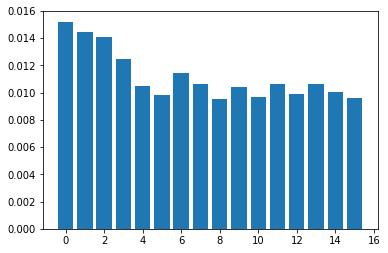

In [147]:
%matplotlib inline
plt.bar(np.arange(16), time_it_took)
plt.show()

# Here we plot the runtime as n increases

We plot time taken as n goes from 1 to 11. We are also conducting 10000 trials (more than previous as we only have 5 functions instead of 16.

Note that answer when n=1 is incorrect half the time because grovers algorithm is stuck in bell states for that case and we get 0 or 1 with equal probablity

In [149]:
time_it_took = []
max_n = 11
lst_bitseq = []
for i in range(max_n):
    lst_bitseq.append([0]*(i+1))
    
for i in range(len(lst_bitseq)):
    start = time.time()
    run_circuit(lambda x: 1 if x == lst_bitseq[i] else 0, i+1, 10000)
    end = time.time()
    time_it_took.append(end-start)

f(x) = 1 for input x = 0 with probability 0.508
f(x) = 1 for input x = 00 with probability 1.000
f(x) = 1 for input x = 000 with probability 0.943
f(x) = 1 for input x = 0000 with probability 0.960
f(x) = 1 for input x = 00000 with probability 0.999
f(x) = 1 for input x = 000000 with probability 0.996
f(x) = 1 for input x = 0000000 with probability 0.996
f(x) = 1 for input x = 00000000 with probability 1.000
f(x) = 1 for input x = 000000000 with probability 1.000
f(x) = 1 for input x = 0000000000 with probability 1.000
f(x) = 1 for input x = 00000000000 with probability 1.000


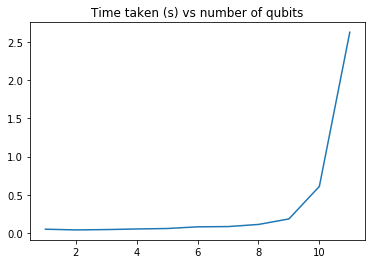

In [150]:
%matplotlib inline
plt.plot(list(range(1,max_n+1)), time_it_took)
plt.title("Time taken (s) vs number of qubits")
plt.show()